# Data Loading & Preprocessing
---

In [2]:
# load libraries and directory
import sys
from pathlib import Path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))
import pandas as pd
import seaborn as sb
from src.utils import *
import warnings
warnings.filterwarnings("ignore")

### > Kelmarsh SCADA Data

The Kelmarsh Windfarm dataset was released by Cubico Sustainable Investments Ltd and contains 10-minute SCADA data from a UK onshore wind farm, including turbine-level readings of wind speed, power output, rotor speed, and status codes.

[Download Here](https://zenodo.org/records/8252025)

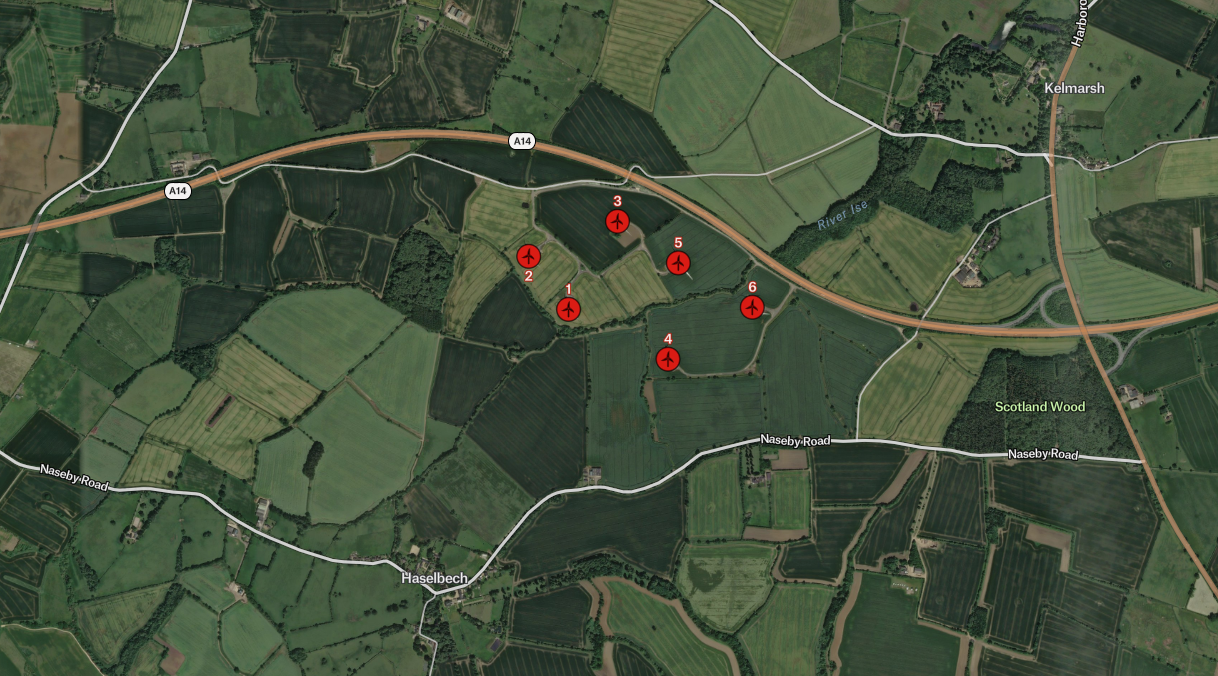

In [3]:
dct_scada, dct_logs = load_kelmarsh_data("../data/kelmarsh_data/SCADA/")

Loading SCADA data & Logs...


In [4]:
print(list(dct_scada.keys()))

wind = dct_scada["T01"]
wind.tail(2)

['T01', 'T02', 'T03', 'T04', 'T05', 'T06']


,Wind speed (m/s),"Wind speed, Standard deviation (m/s)","Wind speed, Minimum (m/s)","Wind speed, Maximum (m/s)",Long Term Wind (m/s),Wind speed Sensor 1 (m/s),"Wind speed Sensor 1, Standard deviation (m/s)","Wind speed Sensor 1, Minimum (m/s)","Wind speed Sensor 1, Maximum (m/s)",Wind speed Sensor 2 (m/s),...,"Tower Acceleration Y, Min (mm/ss)","Tower Acceleration Y, Max (mm/ss)","Drive train acceleration, Max (mm/ss)","Drive train acceleration, Min (mm/ss)","Drive train acceleration, StdDev (mm/ss)","Tower Acceleration X, StdDev (mm/ss)","Tower Acceleration Y, StdDev (mm/ss)",Potential Power Energy Budget (kW),Investment Performance Ratio,Operating Performance Ratio
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-12-31 23:40:00+00:00,9.909597,1.201758,8.068439,13.225472,6.77,10.508158,0.997896,8.875666,12.569854,9.783688,...,18.675150,95.783791,17.346025,17.346025,0.0,35.423549,23.088104,771.063071,2.352156,0.785261
2022-12-31 23:50:00+00:00,10.395954,1.415808,7.542377,12.385334,6.77,10.916051,1.400623,7.929600,13.281394,10.158094,...,16.196264,96.025162,15.628589,15.628589,0.0,40.693253,21.576032,771.063071,2.482849,0.776256


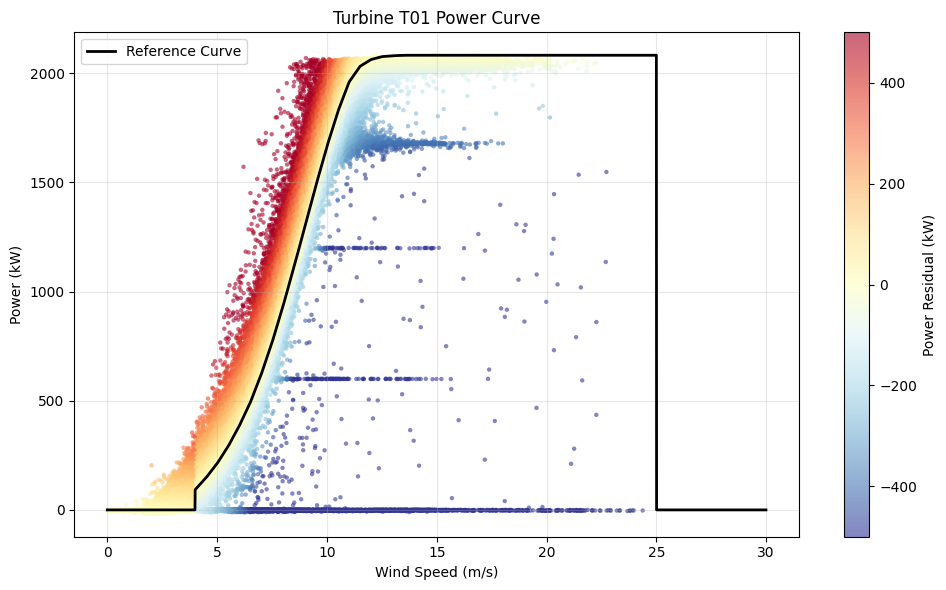

In [5]:
plt.show(plot_turbine_power_curve(wind, "T01", "../data/kelmarsh_data/SCADA/powercurve.csv"))

In [6]:
dct_logs["T01"].head(2)

,Timestamp end,Duration,Status,Code,Message,Comment,Service contract category,IEC category,Global contract category
Timestamp start,,,,,,,,,
2016-01-14 19:28:03+00:00,2016-01-23 14:36:32,211:08:29,Stop,111,Emergency stop nacelle,NaN,Emergency stop switch (Nacelle) (11),Forced outage,NaN
2016-01-14 19:28:03+00:00,2016-01-14 19:38:03,00:10:00,Warning,5720,Brake accumulator defect,NaN,Warnings (27),NaN,NaN


In [7]:
# Reset index once
dct_logs["T01"] = dct_logs["T01"].reset_index()

# Extract intervals for both statuses in one operation
status_intervals = {}
for status in ["Stop", "Warning"]:
    intervals = (
        dct_logs["T01"]
        .loc[dct_logs["T01"]["Status"] == status, ["Timestamp start", "Timestamp end"]]
        .rename(columns={"Timestamp start": "start", "Timestamp end": "end"})
    )
    # Handle missing/invalid timestamps
    intervals = intervals[intervals['end'] != '-'] 
    intervals['end'] = pd.to_datetime(intervals['end'], utc=True, errors='coerce')
    intervals = intervals.dropna()  # Remove any rows where conversion failed
    status_intervals[status.lower()] = intervals

# stop/warning flags
wind[['status_stop', 'status_warning']] = 0
for status, intervals in status_intervals.items():
    col_name = f'status_{status}'
    for start, end in intervals[['start', 'end']].values:
        wind.loc[start:end, col_name] = 1

In [8]:
wind[['status_stop', 'status_warning']].tail(4)

,status_stop,status_warning
timestamp,,
2022-12-31 23:20:00+00:00,0,0
2022-12-31 23:30:00+00:00,0,0
2022-12-31 23:40:00+00:00,0,0
2022-12-31 23:50:00+00:00,0,0


Filter by warning and stopped operations

In [9]:
# Step 1: Operational status and wind speed filtering
running = wind['status_stop'] == 0
no_warning = wind['status_warning'] == 0
valid_wind = wind['Wind speed (m/s)'] > 0.1

# Step 2: Curtailment and setpoint filtering
curtailment_cols = [col for col in wind.columns if 'Curtailment' in col and 'kWh' in col]
no_curtailment = (wind[curtailment_cols] == 0).all(axis=1)

not_derated = wind['Turbine Power setpoint (kW)'] >= 0.99 * wind['Potential power default PC (kW)']

# valid data mask
valid_mask = running & no_warning & valid_wind & no_curtailment & not_derated
clean_data = wind[valid_mask].copy()

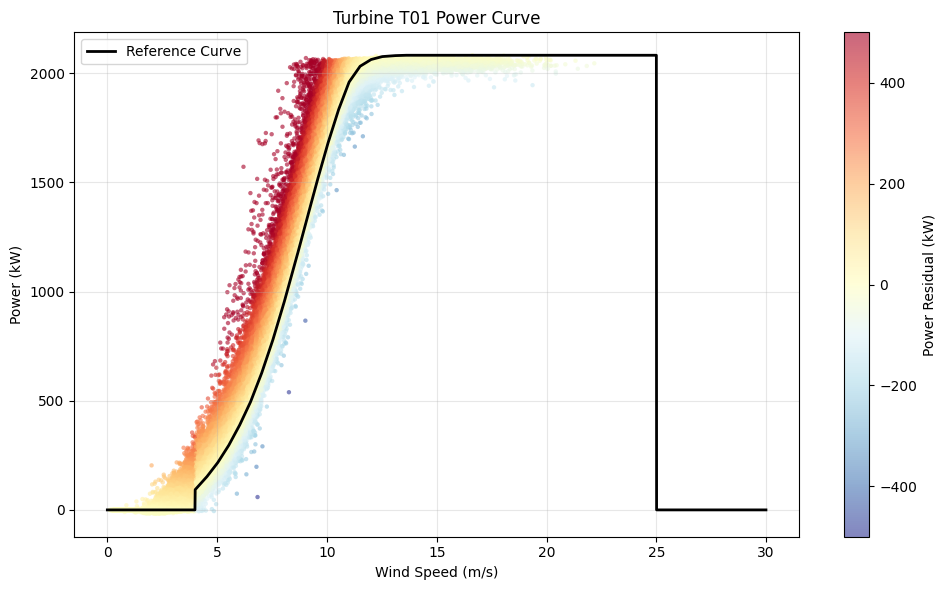

In [10]:
plt.show(plot_turbine_power_curve(clean_data, "T01", "../data/kelmarsh_data/SCADA/powercurve.csv"))


### > ERA5 Weather MetaData
ERA5-Land is a reanalysis dataset providing a consistent view of the evolution of land variables over several decades at an enhanced resolution compared to the Fifth Generation of the European Centre for Medium-Range Weather Forecasts (ECMWF) Reanalysis (ERA5).

[Download Here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-timeseries?tab=download)

In [11]:
# Load and merge with SCADA Data
era5 = pd.read_csv(r"../data/kelmarsh_data/era5/combined_era5.csv",
                   parse_dates=["date"],
                   index_col="date")

era5.index = era5.index.tz_localize('UTC')

# Forward fill to fix frequency issue (hourly -> 10 minutes)
era5_upsampled = era5.reindex(clean_data.index, method = "ffill")
merged = clean_data.join(era5_upsampled, how='inner')
merged.tail(2)

,Wind speed (m/s),"Wind speed, Standard deviation (m/s)","Wind speed, Minimum (m/s)","Wind speed, Maximum (m/s)",Long Term Wind (m/s),Wind speed Sensor 1 (m/s),"Wind speed Sensor 1, Standard deviation (m/s)","Wind speed Sensor 1, Minimum (m/s)","Wind speed Sensor 1, Maximum (m/s)",Wind speed Sensor 2 (m/s),...,soil_temp_l1,soil_temp_l2,soil_temp_l3,soil_temp_l4,vol_soil_water_l1,vol_soil_water_l2,vol_soil_water_l3,vol_soil_water_l4,wind_u_comp_10m,wind_v_comp_10m
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-12-31 23:40:00+00:00,9.909597,1.201758,8.068439,13.225472,6.77,10.508158,0.997896,8.875666,12.569854,9.783688,...,281.62988,281.1469,280.30817,283.7229,0.501953,0.498474,0.488403,0.454651,5.115723,4.781128
2022-12-31 23:50:00+00:00,10.395954,1.415808,7.542377,12.385334,6.77,10.916051,1.400623,7.929600,13.281394,10.158094,...,281.62988,281.1469,280.30817,283.7229,0.501953,0.498474,0.488403,0.454651,5.115723,4.781128


Subset data to key variables (Gijon et Al., 2025)

| Symbol     | Descriptor                   | Unit      | Variable Name       |
| :--------- | :--------------------- | :-------- | :--------------------------------------------------- |
| $v$        | Wind speed             | m/s       | 'Wind speed (m/s)'                                   |
| $\theta$   | Wind direction         | rad       | 'Wind direction (°)'                                 |
| $\omega$   | Rotor angular speed    | rad/s     | 'Rotor speed (RPM)'                                  |
| $T_{out}$  | Outdoor temperature    | °C        | 'Nacelle ambient temperature (°C)'                   |
| $T_{n}$    | Nacelle temperature    | °C        | 'Nacelle temperature (°C)'                           |
| $T_{r}$    | Rotor temperature      | °C        | 'Rotor bearing temp (°C)'                            |
| $\alpha_v$ | Vane angle             | rad       | 'Vane position 1+2 (°)'                              |
| $\alpha_w$ | Pitch angle            | rad       | 'Blade angle (pitch position) A (°)'                 |
| $P$        | Generated power        | kW        | 'Power (kW)'                                         |

In [12]:
final_data = merged[[
    'Power (kW)',
    'Wind speed (m/s)',
    'Wind direction (°)',
    'Ambient temperature (converter) (°C)',
    'surface_pressure',
    'Nacelle temperature (°C)',
    'Rotor bearing temp (°C)',
    'Vane position 1+2 (°)',
    'Blade angle (pitch position) A (°)'
]]

<Axes: >

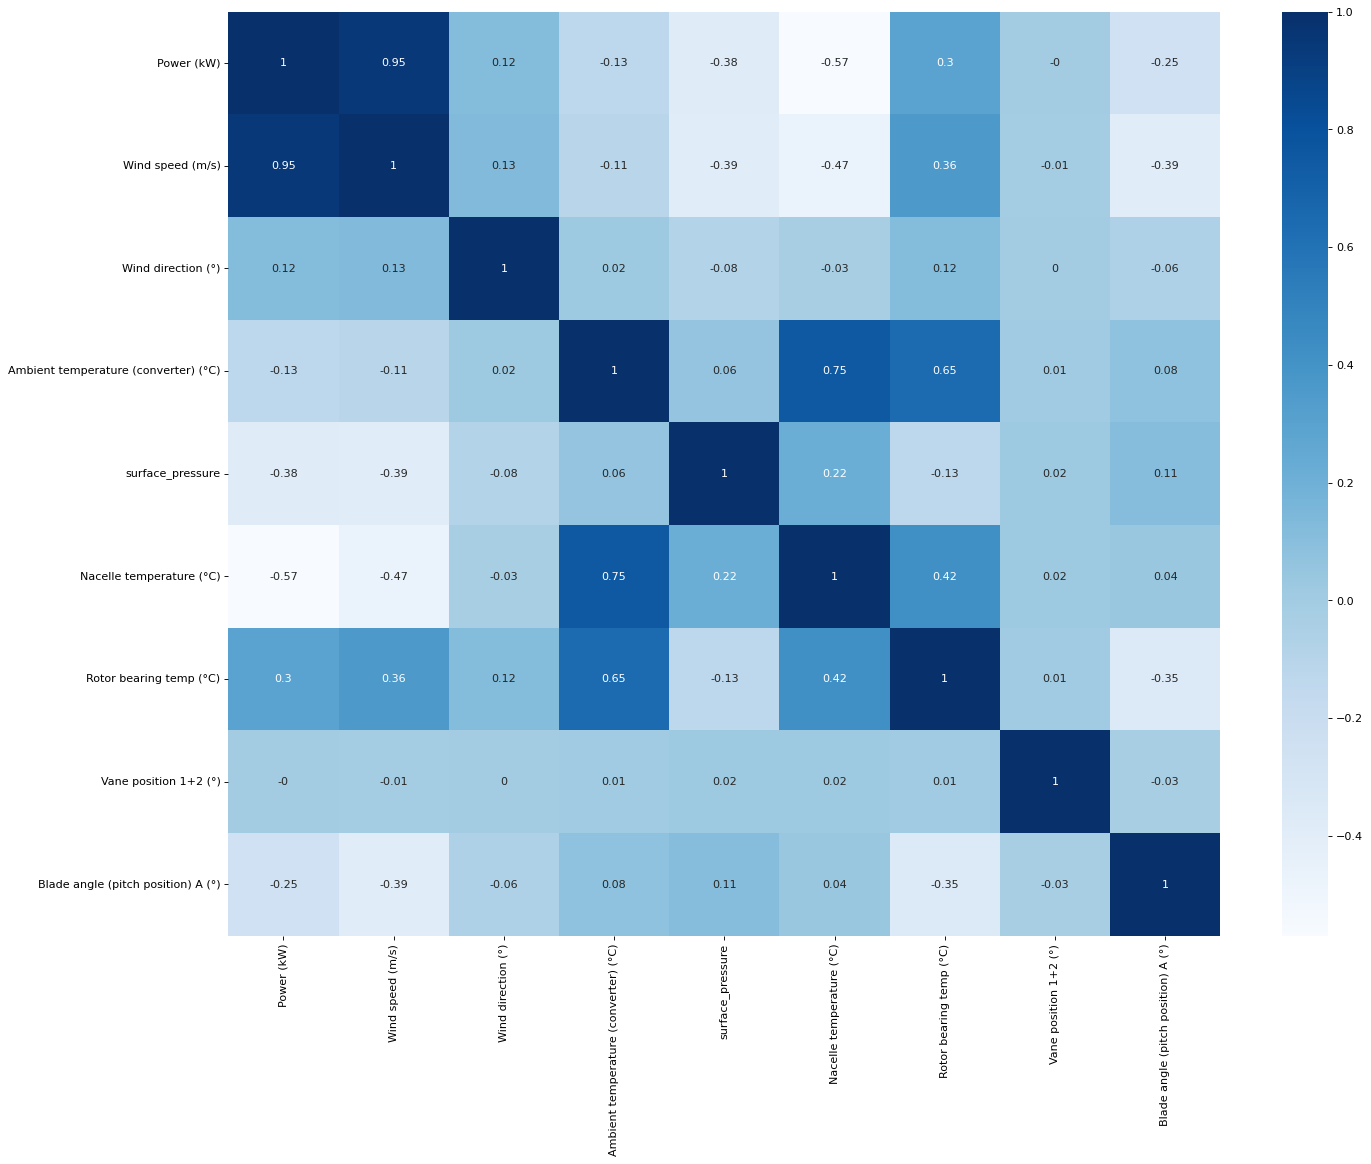

In [13]:
corr = final_data.corr()
plt.figure(figsize=(20, 15), dpi=80)
sb.heatmap(round(corr,2), cmap="Blues", annot=True)

In [14]:
final_data.head()

,Power (kW),Wind speed (m/s),Wind direction (°),Ambient temperature (converter) (°C),surface_pressure,Nacelle temperature (°C),Rotor bearing temp (°C),Vane position 1+2 (°),Blade angle (pitch position) A (°)
timestamp,,,,,,,,,
2018-02-07 16:50:00+00:00,230.004196,4.655283,303.985748,6.563158,100624.080,19.328947,22.121054,13.122903,0.0
2018-02-07 17:00:00+00:00,162.985474,4.620287,297.114929,6.292500,100633.164,19.400000,22.197500,-4.288875,0.0
2018-02-07 17:10:00+00:00,241.258591,5.234799,298.920441,5.985000,100633.164,19.400000,22.200001,-4.610219,0.0
2018-02-07 17:20:00+00:00,267.387878,5.270439,296.782379,5.682500,100633.164,19.610001,22.255001,-8.815373,0.0
2018-02-07 17:30:00+00:00,242.612671,5.014425,297.593323,5.442500,100633.164,19.900000,22.400000,-2.652685,0.0


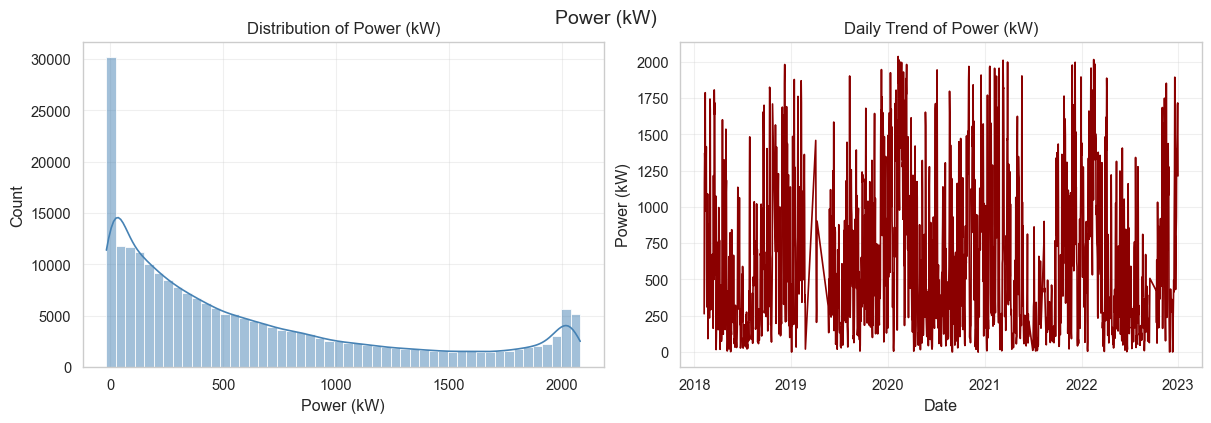

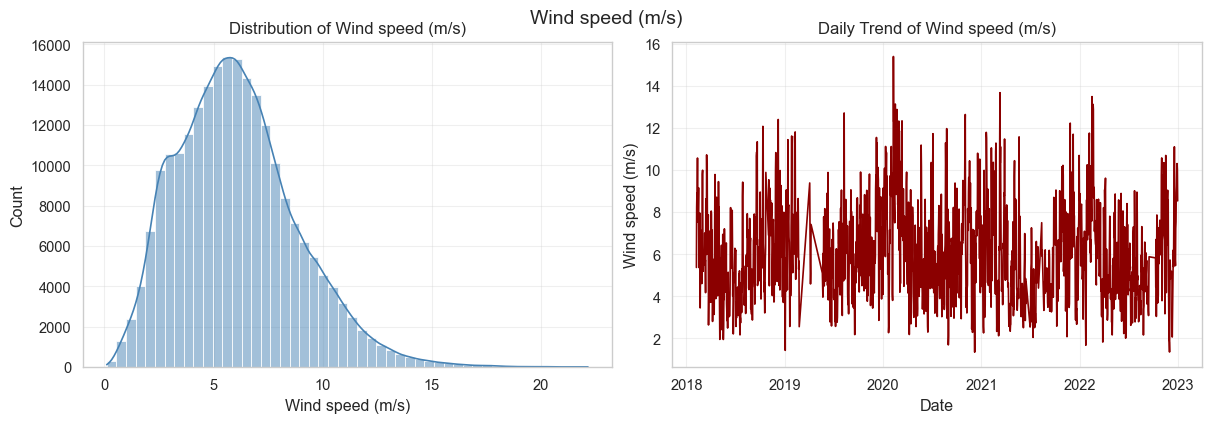

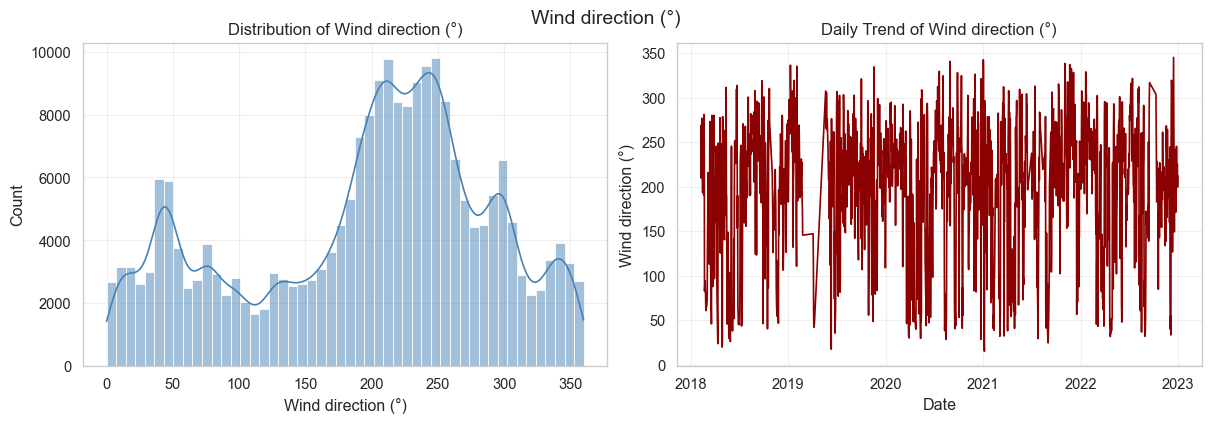

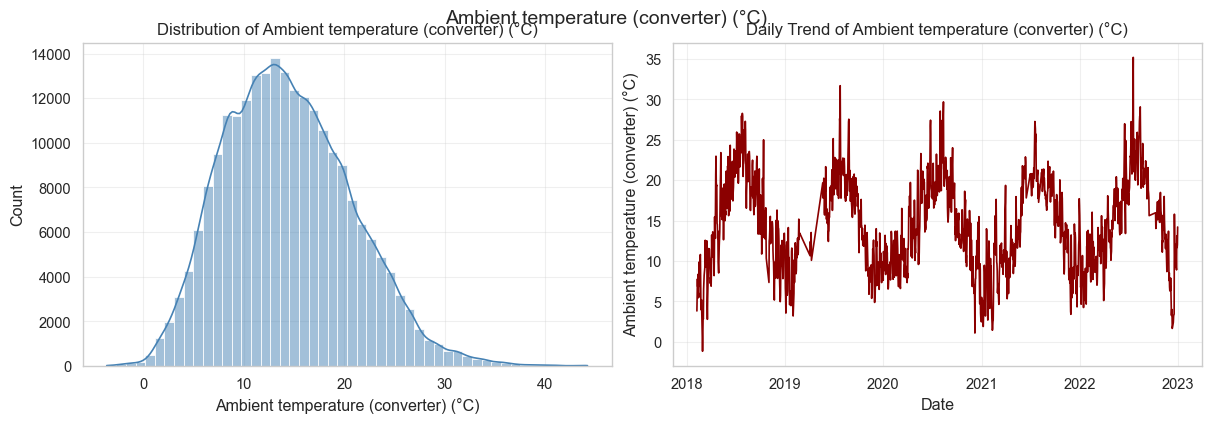

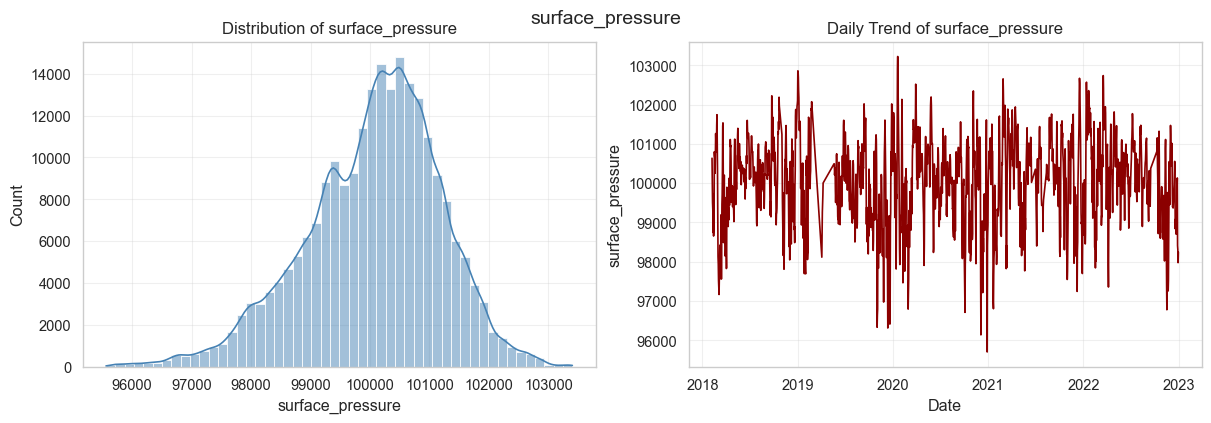

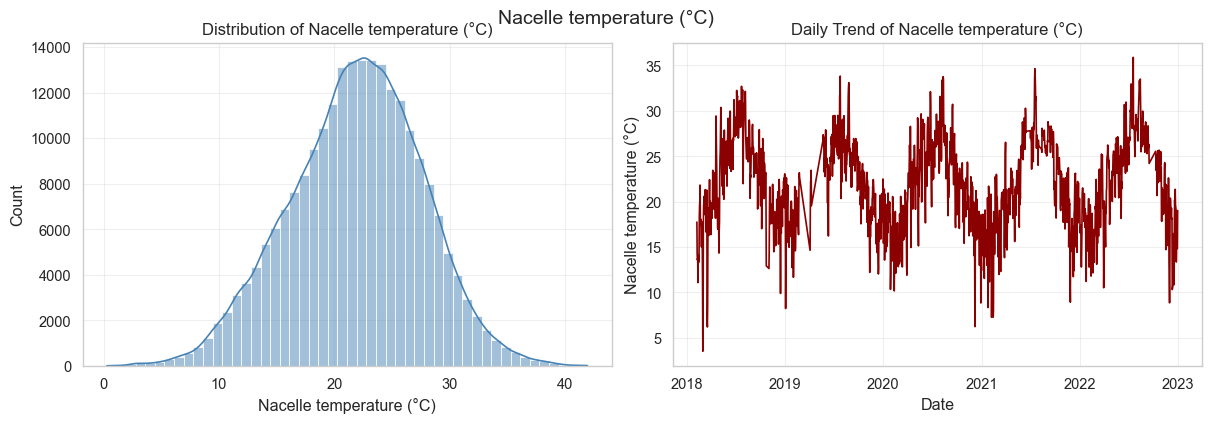

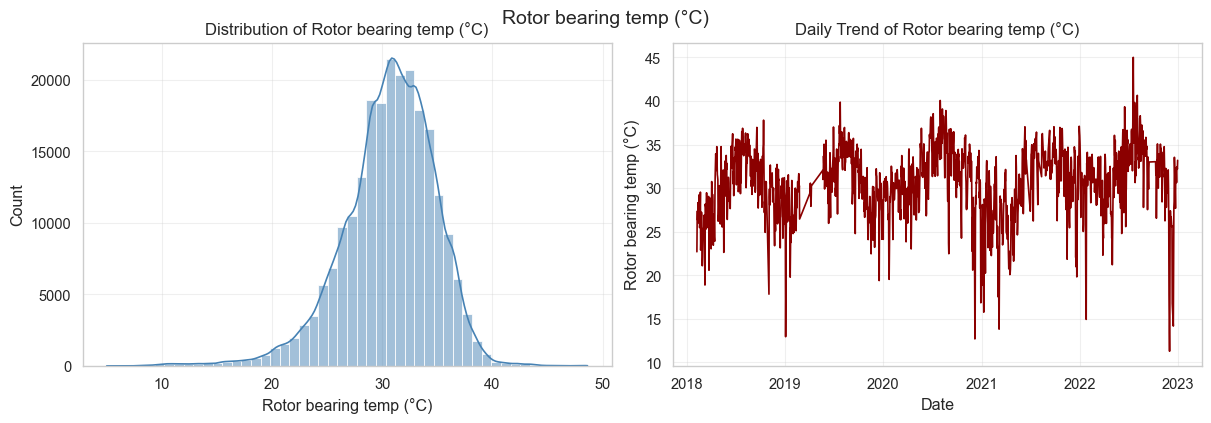

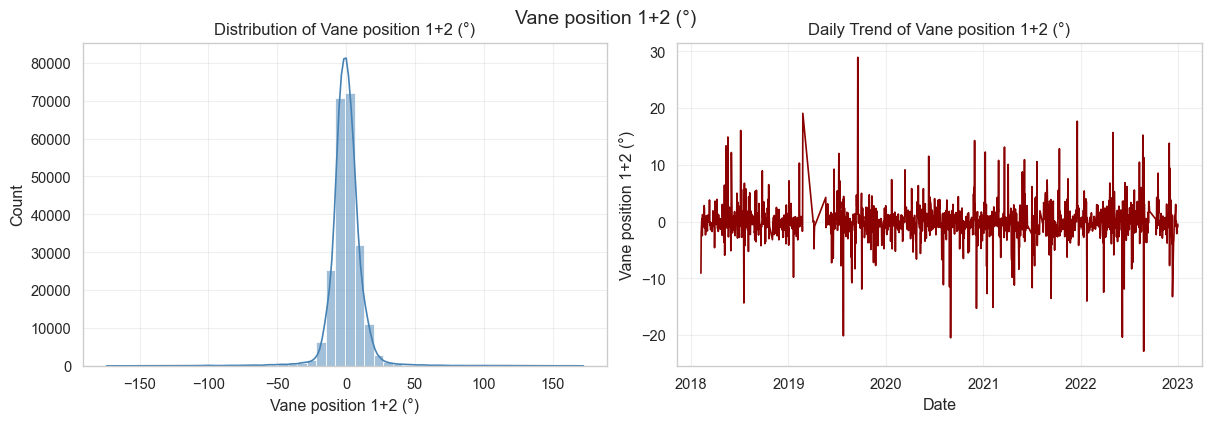

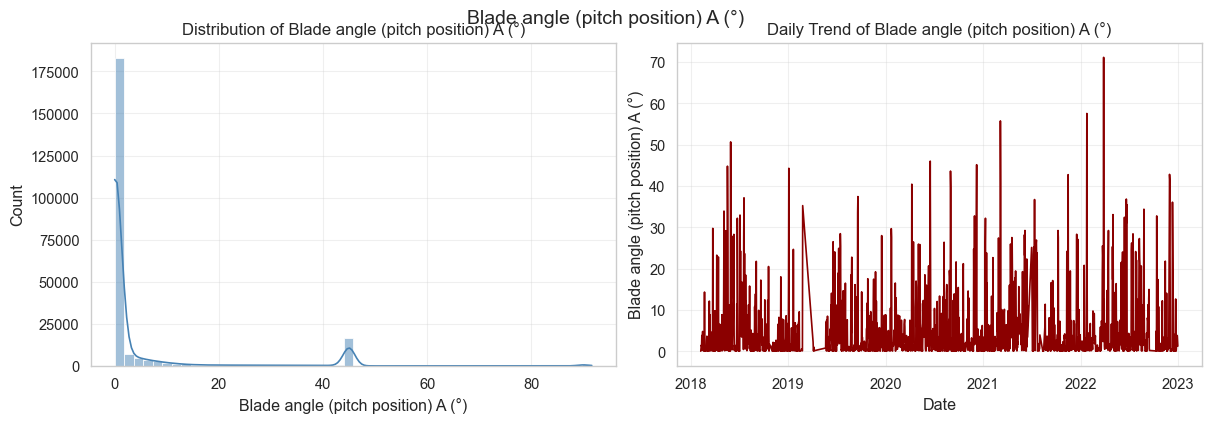

In [18]:
daily_data = final_data.resample('D').mean()

sb.set(style='whitegrid', context='paper', font_scale=1.2)

for col in final_data.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # Distribution
    sb.histplot(final_data[col], kde=True, bins=50, color='steelblue', ax=axes[0])
    axes[0].set_title(f'Distribution of {col}', fontsize=12)

    # Time Series
    sb.lineplot(data=daily_data[col], color='darkred', ax=axes[1])
    axes[1].set_title(f'Daily Trend of {col}', fontsize=12)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel(col)

    fig.suptitle(col, fontsize=14, y=1.02)
    plt.show()

In [15]:
final_data.to_pickle("t1_data.pkl")